In [1]:
from helpers import toWei, fromWei, Market

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Market Parameters

Here are the market parameters. The rest of the notebook is designed so that if you change these parameters, the rest of the notebook should execute correctly.

For context, the Rinkeby faucet gives:
- 3 Ether with 8 hour wait
- ~19 Ether with a 3 day wait

The principles guiding decisions on parameters:
- Tie ETH denominated params to the real rate at which Rinkeby testnet tokens can be minted
- Make it possible for a user to hit the Rinkeby faucet once and afford several market functions that cost tokens (buy, support). This means costs in the range of 0.1 - 10 ETH.
- Make it possible, with some work, for users to get enough CMT to exceed stake and participate in votes
- Make it hard for a single entity to get enough CMT to overwhelm the market creator (short of being a Rinkeby token whale which we can't stop)

In [2]:
params = {
#    'price_floor_human':    0, # ETH per CMT.
    
    'spread':               200,
    # Create significant barrier to buying equal voting power without using price_floor. Also,
    # create steeper incentive to support early.
    
    'list_reward':          toWei(0.25, 'CMT'),
    # Large enough to feel non-trivial as a fraction of whole CMT, 
    # but small enough that list rewards alone can't be easily used to get much CMT.
    
    'stake':                toWei(20, 'CMT'),
    # This one's tricky. Too high and we prevent community participation in votes and limit our own
    # voting power. Too low and we create attack risk* (Actually I'm becoming less convinced this statement
    # is true. Lower stake means its easier for an attacker to get voting power, but it also should broaden
    # the base of good actors who can vote. Lower stake also increases our voting power.)
    
    'backend_payment':      5, # percent
    # This could be 0 since the money's fake and Datatrust doesn't need it, but
    # we could also leave at 5 just to reflect the setting we'd choose for ffa-mainnet. Another reason
    # to leave > 0 is this becomes a source of ETH income to pump back in to market to maintain control
    # without having to go to the faucet.
    
    'maker_payment':        50, # percent. 
    # Increased from initial skynet deployment which had it at 30. 
    # Reasoning is it takes real effort to determine and upload a file that gets used.
    # Compensate for fact that ETH is fake (but still kinda motivating like game points) and
    # give some extra to the makers.
    
    # reserve payment:      100 - backend_payment - maker_payment
    
    'cost_per_byte':        toWei(1e-8, 'ETH'), # 1 ETH for 100MB
    # A scan through some Kaggle datasets, the size of videos, photos, and sound files, and came
    # up with 100MB as a reference listing size. Let's make buying this reference 1 ETH. You can 
    # easily get 3 ETHs from the faucet and buy 3 things.
}

CREATOR_BLOCK_SIZE =       toWei(2000, 'CMT')
CREATOR_INITIAL_SUPPORT =  toWei(200, 'ETH')
# These are set so that creator starts with 100 stakes worth of voting power
# and initial (non-creator) price per CMT is a significant fraction of 1 ETH (0.1 - 0.5)

In [3]:
# Convert human readable floor to units used by market codebase
params['price_floor'] = 1e6 # wei per billion CMT-wei
params['reserve_payment'] = 100 - params['backend_payment'] - params['maker_payment']

## Scenario: simple sequence of supporting, listing, buying

In [4]:
# (re)create a fresh market
m = Market(params)
m.market_total += CREATOR_BLOCK_SIZE
m.reserve += CREATOR_INITIAL_SUPPORT 

iters = 1000

support_prices = np.zeros(iters)
withdraw_prices = np.zeros(iters)

for i in range(iters):
    m.support(1)
    m.list()
    for j in range(5):
        m.buy(20)
    
    support_prices[i] = m.get_human_support_price()
    withdraw_prices[i] = m.get_withdraw_price()

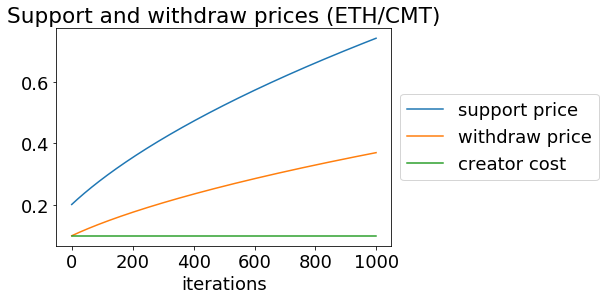

In [5]:
creator_price = CREATOR_INITIAL_SUPPORT/CREATOR_BLOCK_SIZE
creator_prices = np.full(iters, creator_price)

plt.rc('font', size=18)
fig, ax = plt.subplots()

x = np.arange(0, iters, 1)
ax.plot(x, support_prices)
ax.plot(x, withdraw_prices)
ax.plot(x, creator_prices)
ax.legend(['support price', 'withdraw price', 'creator cost'], loc='center left', bbox_to_anchor=(1, 0.5))

ax.set(xlabel='iterations', title='Support and withdraw prices (ETH/CMT)')
plt.show()

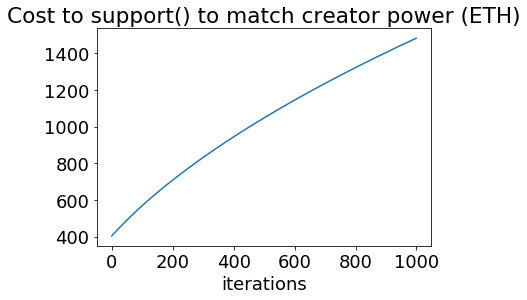

In [6]:
costs_to_match_creator = fromWei(CREATOR_BLOCK_SIZE, 'CMT') * support_prices

fig, ax = plt.subplots()
ax.plot(x, costs_to_match_creator)
ax.set(xlabel='iterations', title='Cost to support() to match creator power (ETH)')
plt.show()

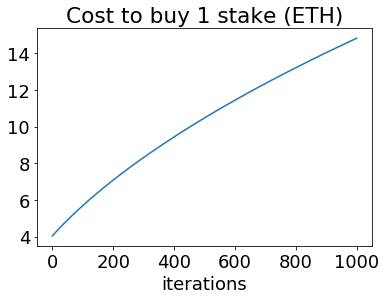

In [7]:
costs_to_stake = fromWei(params['stake'], 'CMT') * support_prices

fig, ax = plt.subplots()
ax.plot(x, costs_to_stake)
ax.set(xlabel='iterations', title='Cost to buy 1 stake (ETH)')
plt.show()

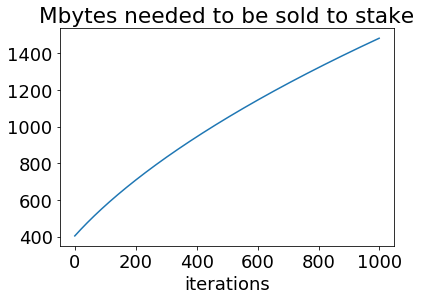

In [8]:
mb_sold_to_stake = costs_to_stake / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_stake)
ax.set(xlabel='iterations', title='Mbytes needed to be sold to stake')
plt.show()

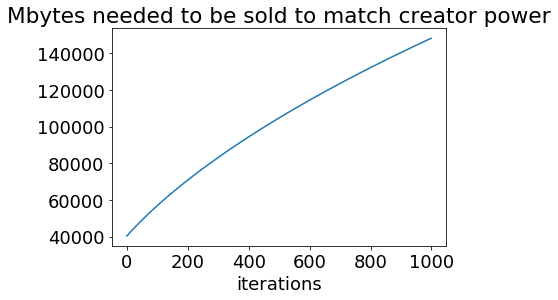

In [9]:
mb_sold_to_match_creator = costs_to_match_creator / (fromWei(params['cost_per_byte'], 'ETH') * 1e6)
fig, ax = plt.subplots()
ax.plot(x, mb_sold_to_match_creator)
ax.set(xlabel='iterations', title='Mbytes needed to be sold to match creator power')
plt.show()

In [10]:
print(f"• The creator has {int(CREATOR_BLOCK_SIZE/params['stake'])} stakes of voting power")

listings_approved_to_match_creator = CREATOR_BLOCK_SIZE / params['list_reward']
print(f"• It takes {int(listings_approved_to_match_creator)} listings to match creator voting power")



• The creator has 100 stakes of voting power
• It takes 8000 listings to match creator voting power


## Scenario: How much sales does it take to break even?
User buys 1 ETH worth of CMT at a given support price. How much in sales needs to happen
in order to break even on that 1 ETH investment?

In [11]:
iters = 500

support_price = np.zeros(iters)
mb_needed = np.zeros(iters)

for i in range(iters):
    
    # (re)create a fresh market
    m = Market(params)
    m.market_total += CREATOR_BLOCK_SIZE
    m.reserve += CREATOR_INITIAL_SUPPORT 

    for j in range(i):
        # simulate a bunch of buys to get price up before
        # I buy
        m.support(1)
    
    # Now I'm going to buy 1 ETH worth
    m.support(1)
    my_support_price = m.get_human_support_price()
    support_price[i] = my_support_price
    
    # now simulate purchases until withdraw price
    # is same as what I paid.
    
    my_withdraw_price = m.get_withdraw_price()
    mb_counter = 0
    while my_withdraw_price < my_support_price:
        m.buy(10) # buy 1 Mb
        mb_counter += 10
        my_withdraw_price = m.get_withdraw_price()
        
    mb_needed[i] = mb_counter

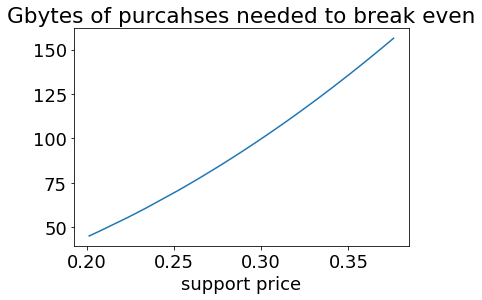

In [12]:
fig, ax = plt.subplots()
ax.plot(support_price, mb_needed/1000)
ax.set(xlabel='support price', title='Gbytes of purcahses needed to break even')
plt.show()